stackingのアンサンブル用シート

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.linear_model import LinearRegression
import xgboost

Duplicate key in file PosixPath('/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc'), line 258 ('font.family : IPAexGothic')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
###訓練データの読み込み
house_age = pd.read_csv('house_age.csv')
area_size = pd.read_csv('area_size.csv')
room_arrange = pd.read_csv('room_arrange.csv')
contract_span = pd.read_csv('contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('reg_rent.csv')
floor_scores = pd.read_csv('floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('stations.csv')
minits = pd.read_csv('minits.csv')
addresses = pd.read_csv('addresses.csv')
room_arrange = pd.read_csv('room_arrange.csv')
buildings = pd.read_csv('buildings.csv')

rent = pd.read_csv('rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('test_house_age.csv')
test_area_size = pd.read_csv('test_area_size.csv')
test_room_arrange = pd.read_csv('test_room_arrange.csv')
test_contract_span = pd.read_csv('test_contract_span.csv')
test_contract_span2 = pd.read_csv('test_contract_span2.csv')
test_reg_rent = pd.read_csv('test_reg_rent.csv')
test_floor_scores = pd.read_csv('test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('test_capital_floor_scores2.csv')
test_stations = pd.read_csv('test_stations.csv')
test_minits = pd.read_csv('test_minits.csv')
test_addresses = pd.read_csv('test_addresses.csv')
test_room_arrange = pd.read_csv('test_room_arrange.csv')
test_buildings = pd.read_csv('test_buildings.csv')

lightGBMとDARTとGOSSとXGBoostでstackingのstackingアンサンブルを行う。

In [77]:
X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, addresses, room_arrange[["部屋数","L","D","K","S"]]], axis=1)
y_train = rent
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_addresses, test_room_arrange[["部屋数","L","D","K","S"]]], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
sX_train, sX_valid, sy_train, sy_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [81]:
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','K','S']

####LisgtGBM###
lgb_train = lgb.Dataset(sX_train, sy_train)
lgb_eval = lgb.Dataset(sX_valid, sy_valid, reference=lgb_train)
params_LGBM = {
    'objective':'regression',
    'metrics':'rmse',
    'reg_lambda': 4.430375245218262e-06,
    'max_bin': 502,
    'num_leaves': 97
}
model_LGBM = lgb.train(
                    params_LGBM,
                    lgb_train, 
                    valid_sets=[lgb_train, lgb_eval], 
                    verbose_eval=10, 
                    num_boost_round=3000, 
                    early_stopping_rounds=10,
                    categorical_feature = category_lists
                    )

###DART###
lgb_train = lgb.Dataset(sX_train, sy_train)
lgb_eval = lgb.Dataset(sX_valid, sy_valid, reference=lgb_train)
params_DART = {
    'objective':'regression',
    'boosting_type':'dart',
    'metrics':'rmse',
    'reg_lambda': 2.1600820741402023e-05,
    'max_bin': 556,
    'num_leaves': 126
}

model_DART = lgb.train(
                    params_DART,
                    lgb_train, 
                    valid_sets=[lgb_train, lgb_eval], 
                    verbose_eval=10, 
                    num_boost_round=1000, 
                    early_stopping_rounds=10,
                    categorical_feature = category_lists
                    )

###GOSS###
lgb_train = lgb.Dataset(sX_train, sy_train)
lgb_eval = lgb.Dataset(sX_valid, sy_valid, reference=lgb_train)
params_GOSS = {
    'objective':'regression',
    'boosting_type':'goss',
    'metrics':'rmse',
    'reg_lambda': 1.2667345328336822e-06,
    'max_bin': 405,
    'num_leaves': 118
}

model_GOSS = lgb.train(
                    params_GOSS,
                    lgb_train, 
                    valid_sets=[lgb_train, lgb_eval], 
                    verbose_eval=10, 
                    num_boost_round=1000, 
                    early_stopping_rounds=10,
                    categorical_feature = category_lists
                    )

###XGBoost###
xgb_reg = xgboost.XGBRegressor(
    #目的関数の指定 初期値も二乗誤差です
                       objective='reg:linear',
                       #学習のラウンド数 early_stoppingを利用するので多めに指定
                       n_estimators=50000,
                       #boosterに何を用いるか 初期値もgbtreeです
                       booster='gbtree',
                       #学習率
                       learning_rate=0.01,
                       #木の最大深さ
                       max_depth=7,
                       #シード値
                       random_state=0,
                        #正則化
                       reg_alfa=6.456897906217094e-07,

                       sub_sample=0.2733678333806067,

                       colsample_bytree=0.7591887378820503,

                       min_child_weight=5
)
xgb_reg.fit(sX_train, sy_train, eval_set=[(sX_valid, sy_valid)], early_stopping_rounds=10)

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2344
[LightGBM] [Info] Number of data points in the train set: 22658, number of used features: 14
[LightGBM] [Info] Start training from score 118575.175126
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 36372.3	valid_1's rmse: 33759.7
[20]	training's rmse: 21709.7	valid_1's rmse: 23309.5
[30]	training's rmse: 16239.6	valid_1's rmse: 20032.7
[40]	training's rmse: 13803.8	valid_1's rmse: 18571.5
[50]	training's rmse: 12507.8	valid_1's rmse: 18066.7
[60]	training's rmse: 11542.8	valid_1's rmse: 17733.7
[70]	training's rmse: 10717.6	valid_1's rmse: 17577.9
[80]	training's rmse: 10096.5	valid_1's rmse: 17404.8
[90]	training's rmse: 9521.52	valid_1's rmse: 17307
[100]	training's rmse: 9024.2	valid_1's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[30]	training's rmse: 18050.9	valid_1's rmse: 22307.4
[40]	training's rmse: 16741.5	valid_1's rmse: 21174.9
[50]	training's rmse: 21253.1	valid_1's rmse: 25014.9
[60]	training's rmse: 25274.4	valid_1's rmse: 28718.3
[70]	training's rmse: 24147.7	valid_1's rmse: 27873.2
[80]	training's rmse: 19309.7	valid_1's rmse: 23821.6
[90]	training's rmse: 19747.3	valid_1's rmse: 23987.7
[100]	training's rmse: 20659.4	valid_1's rmse: 25059.3
[110]	training's rmse: 26743.5	valid_1's rmse: 30214.6
[120]	training's rmse: 18822.5	valid_1's rmse: 23550.6
[130]	training's rmse: 16915	valid_1's rmse: 22151.1
[140]	training's rmse: 19290.1	valid_1's rmse: 24148.4
[150]	training's rmse: 18234.3	valid_1's rmse: 23223.8
[160]	training's rmse: 22267.7	valid_1's rmse: 26480.6
[170]	training's rmse: 16346.4	valid_1's rmse: 21819.5
[180]	training's rmse: 15756.5	valid_1's rmse: 21530.2
[190]	training's rmse: 13415.4	valid_1's rmse: 20056.5
[200]	training's rmse: 13255.4	valid_1's rmse: 20100.5
[210]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-rmse:117831.94033
[17]	validation_0-rmse:116732.70501
[18]	validation_0-rmse:115640.96537
[19]	validation_0-rmse:114558.22322
[20]	validation_0-rmse:113578.88476
[21]	validation_0-rmse:112557.66968
[22]	validation_0-rmse:111607.81183
[23]	validation_0-rmse:110588.14379
[24]	validation_0-rmse:109641.80339
[25]	validation_0-rmse:108638.52416
[26]	validation_0-rmse:107652.68102
[27]	validation_0-rmse:106746.78588
[28]	validation_0-rmse:105771.88154
[29]	validation_0-rmse:104888.77709
[30]	validation_0-rmse:103939.75629
[31]	validation_0-rmse:103095.07954
[32]	validation_0-rmse:102255.74737
[33]	validation_0-rmse:101333.09980
[34]	validation_0-rmse:100413.38545
[35]	validation_0-rmse:99575.20359
[36]	validation_0-rmse:98741.42847
[37]	validation_0-rmse:97856.28741
[38]	validation_0-rmse:97060.79882
[39]	validation_0-rmse:96270.13857
[40]	validation_0-rmse:95495.32836
[41]	validation_0-rmse:94729.38647
[42]	validation_0-rmse:93982.44235
[43]	validation_0-rmse:93228.27944
[

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.7591887378820503, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=7, max_leaves=0,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=50000, n_jobs=0, num_parallel_tree=1,
             objective='reg:linear', predictor='auto', random_state=0,
             reg_alfa=6.456897906217094e-07, ...)

ブレンドのモデルがランダムフォレストの場合

In [82]:
# 個別のモデルの予測値たち。
valid_pred_LGBM = model_LGBM.predict(X_valid)
valid_pred_DART = model_DART.predict(X_valid)
valid_pred_GOSS = model_GOSS.predict(X_valid)
valid_pred_XGB = xgb_reg.predict(X_valid)

# ブレンドの特徴量になるものをまとめる。
stack_pred = np.column_stack((valid_pred_LGBM,valid_pred_LGBM,valid_pred_GOSS,valid_pred_XGB))

# ブレンドの作成。
blend_model = RandomForestRegressor()
# ブレンドの特徴量として作ったデータと元データのy_validでブレンドを学習させる。
blend_model.fit(stack_pred, y_valid)

# ここのモデルによるテストデータからの予測値
pred_LGBM = model_LGBM.predict(X_test)
pred_DART = model_DART.predict(X_test)
pred_GOSS = model_GOSS.predict(X_test)
pred_XGB = xgb_reg.predict(X_test)

pred_LGBM = pd.DataFrame(pred_LGBM)
pred_DART = pd.DataFrame(pred_DART)
pred_GOSS = pd.DataFrame(pred_GOSS)
pred_XGB = pd.DataFrame(pred_XGB)

#　ブレンドモデルのテストデータを作成
stack_test_pred = np.column_stack((pred_LGBM, pred_DART, pred_GOSS, pred_XGB))
print(stack_test_pred)

blend_pred = blend_model.predict(stack_test_pred)
blend_pred = pd.DataFrame(blend_pred)

/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_1437/1369431801.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  blend_model.fit(stack_pred, y_valid)


[[141589.99059709 135860.41618786 135292.15720724 116818.6015625 ]
 [120638.40479875 121740.7524261  122543.16278988 119498.015625  ]
 [ 82091.47529558  84459.94828367  77582.81571322  84483.5546875 ]
 ...
 [174384.14583592 175273.70533936 174475.52358097 172827.515625  ]
 [263196.46567267 269891.8500648  272626.70045233 278158.5       ]
 [ 82936.46426254  80744.26053754  81891.68970806  82817.9296875 ]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


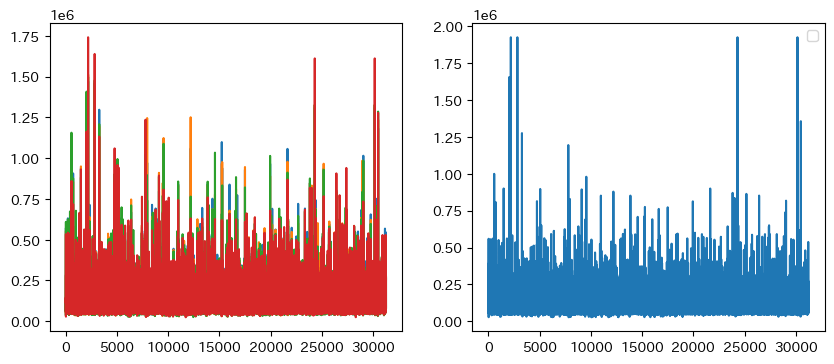

In [83]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.plot(range(len(blend_pred)), pred_LGBM, label='LGBM')
ax.plot(range(len(blend_pred)), pred_DART, label='DART')
ax.plot(range(len(blend_pred)), pred_GOSS, label='GOSS')
ax.plot(range(len(blend_pred)), pred_XGB, label='XGB')

ax2.plot(range(len(blend_pred)), blend_pred)

plt.legend(loc='best')
plt.show()

ブレンドのモデルがLGBMの場合

In [95]:
# 個別のモデルの予測値たち。
valid_pred_LGBM = model_LGBM.predict(X_valid)
valid_pred_DART = model_DART.predict(X_valid)
valid_pred_GOSS = model_GOSS.predict(X_valid)
valid_pred_XGB = xgb_reg.predict(X_valid)

# ブレンドの特徴量になるものをまとめる。
stack_pred = np.column_stack((valid_pred_LGBM,valid_pred_LGBM,valid_pred_GOSS,valid_pred_XGB))

# ブレンドの作成。
blend_model = lgb.LGBMRegressor()
# ブレンドの特徴量として作ったデータと元データのy_validでブレンドを学習させる。
blend_model.fit(stack_pred, y_valid)

# ここのモデルによるテストデータからの予測値
pred_LGBM = model_LGBM.predict(X_test)
pred_DART = model_DART.predict(X_test)
pred_GOSS = model_GOSS.predict(X_test)
pred_XGB = xgb_reg.predict(X_test)

pred_LGBM = pd.DataFrame(pred_LGBM)
pred_DART = pd.DataFrame(pred_DART)
pred_GOSS = pd.DataFrame(pred_GOSS)
pred_XGB = pd.DataFrame(pred_XGB)

#　ブレンドモデルのテストデータを作成
stack_test_pred = np.column_stack((pred_LGBM, pred_DART, pred_GOSS, pred_XGB))
print(stack_test_pred)

blend_pred = blend_model.predict(stack_test_pred)
blend_pred = pd.DataFrame(blend_pred)

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[141589.99059709 135860.41618786 135292.15720724 116818.6015625 ]
 [120638.40479875 121740.7524261  122543.16278988 119498.015625  ]
 [ 82091.47529558  84459.94828367  77582.81571322  84483.5546875 ]
 ...
 [174384.14583592 175273.70533936 174475.52358097 172827.515625  ]
 [263196.46567267 269891.8500648  272626.70045233 278158.5       ]
 [ 82936.46426254  80744.26053754  81891.68970806  82817.9296875 ]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


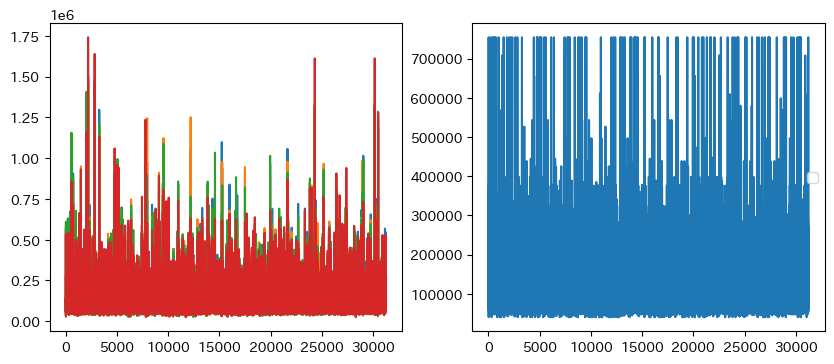

In [96]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.plot(range(len(blend_pred)), pred_LGBM, label='LGBM')
ax.plot(range(len(blend_pred)), pred_DART, label='DART')
ax.plot(range(len(blend_pred)), pred_GOSS, label='GOSS')
ax.plot(range(len(blend_pred)), pred_XGB, label='XGB')

ax2.plot(range(len(blend_pred)), blend_pred)

plt.legend(loc='best')
plt.show()

In [98]:
blend_pred.max()

0    754416.256142
dtype: float64

In [92]:
blend_pred[blend_pred>70000].head()

,0
0,134491.240776
1,121929.919799
2,79866.145973
3,NaN
4,113962.682532


In [85]:
df = pd.read_csv('test.csv')
id = df['id']
y_pred = pd.DataFrame(blend_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('blend_result.csv',index=False)